In [22]:
import velocyto as vcy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [5]:
%matplotlib inline

In [30]:
def default_velocity(
    loom_file=None,
    coords_file=None,
    idents_file=None,
    cmap=None
):
    vlm = vcy.VelocytoLoom(loom_file)
    mtsne = pd.read_csv(coords_file, index_col=0)
    mclusters = pd.read_csv(idents_file, index_col=0)
    cellid = vlm.ca['CellID'].astype(str)
    cellid = np.char.rstrip(cellid, 'x')
    cellid = np.char.replace(cellid, '_', '')
    cellid = np.char.replace(cellid, ':', '_')
    vlm.ca['CellID'] = cellid
    vlm.filter_cells(bool_array=np.isin(vlm.ca['CellID'], mtsne.index))
    vlm.ca['_X'] = mtsne.loc[vlm.ca['CellID']]['UMAP_1']
    vlm.ca['_Y'] = mtsne.loc[vlm.ca['CellID']]['UMAP_2']
    vlm.ts = np.column_stack([vlm.ca['_X'], vlm.ca['_Y']])
    vlm.set_clusters(mclusters.loc[vlm.ca['CellID'], 'x'], cluster_colors_dict=cmap)
    vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.4))
    vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
    vlm.filter_genes(by_detection_levels=True)
    vlm.score_cv_vs_mean(3000, max_expr_avg=35)
    vlm.filter_genes(by_cv_vs_mean=True)
    vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0, min_expr_counts_U=25, min_cells_express_U=20)
    vlm.score_cluster_expression(min_avg_U=0.01, min_avg_S=0.08)
    vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
    vlm._normalize_S(relative_size=vlm.initial_cell_size,
                     target_size=np.mean(vlm.initial_cell_size))
    vlm._normalize_U(relative_size=vlm.initial_Ucell_size,
                     target_size=np.mean(vlm.initial_Ucell_size))
    vlm.perform_PCA()
    return vlm

def estimate_n_comps(vlm, override=None):
    plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
    n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_)) > 0.002))[0][0]
    if override is not None:
        n_comps = override
    plt.axvline(n_comps, c="k")
    return n_comps

def continue_velocity(vlm, c_comps):
    k = 50
    vlm.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)
    vlm.fit_gammas(limit_gamma=False, fit_offset=False)
    vlm.predict_U()
    vlm.calculate_velocity()
    vlm.calculate_shift(assumption="constant_velocity")
    vlm.extrapolate_cell_at_t(delta_t=1.)
    vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                                 n_neighbors=200, knn_random=True, sampled_fraction=0.5)
    vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
    vlm.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=30)

def plot(vlm, cmap):
    plt.figure(None,(10,10))
    vlm.plot_grid_arrows(
        #quiver_scale=0.48,
        scatter_kwargs_dict={
            "alpha": 0.35, 
            "lw": 0.35, 
            "edgecolor": "0.4", 
            "s": 38, 
            "rasterized": True,
        }, 
        #min_mass=2, 
        angles='xy', 
        scale_units='xy',
        headaxislength=2.75, 
        headlength=5, 
        headwidth=4.8, 
        minlength=1.5,
        #plot_random=True, 
        #scale_type="absolute"
    )
    plt.legend(
        (matplotlib.lines.Line2D(
            [0], 
            [0], 
            marker='o', 
            color='w', 
            markerfacecolor=color,
            markersize=10
        ) for color in cmap.values()),
        (cmap.keys()),
        fontsize=14
    )

In [7]:
macrophages_cmap = {
    "AM1": [1, 0x66 / 255, 0x61 / 255],
    "AM2": [0x9e / 255, 0xab / 255, 0],
    "AM3": [0, 0xc8 / 255, 0x80 / 255],
    "IM1": [0, 0xae / 255, 0xfa / 255],
    "IM2": [1, 0x3b / 255, 0xf3 / 255],
}

In [18]:
tio2_macs = default_velocity(
    loom_file="../../SC_14.loom", 
    coords_file="../../macrophages-umap.csv",
    idents_file="../../macrophages-ident.csv",
    cmap=macrophages_cmap
)

/home/nmx5063/.local/share/virtualenvs/rna-velocity-9bSdH9Bk/lib/python3.6/site-packages/loompy/loom_validator.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(path) as f:


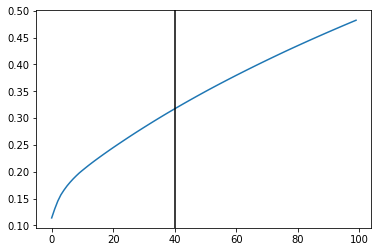

In [34]:
tio2_macs_comps = estimate_n_comps(tio2_macs, override=40)

In [35]:
continue_velocity(tio2_macs, tio2_macs_comps)

/home/nmx5063/.local/share/virtualenvs/rna-velocity-9bSdH9Bk/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


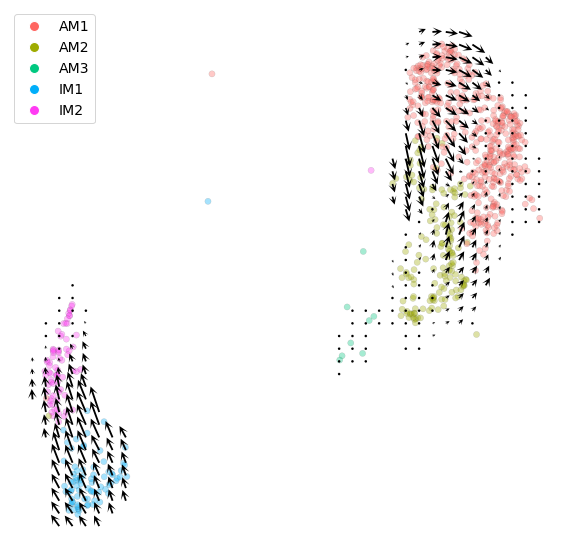

In [36]:
plot(tio2_macs, macrophages_cmap)
plt.savefig("tio2-mac-grid.pdf")

In [25]:
asbestos_macs = default_velocity(
    loom_file="../../SC_15.loom", 
    coords_file="../../macrophages-umap.csv",
    idents_file="../../macrophages-ident.csv",
    cmap=macrophages_cmap
)

/home/nmx5063/.local/share/virtualenvs/rna-velocity-9bSdH9Bk/lib/python3.6/site-packages/loompy/loom_validator.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(path) as f:


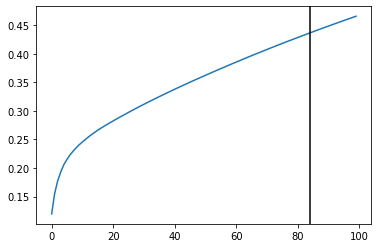

In [37]:
asbestos_macs_comps = estimate_n_comps(asbestos_macs)

In [38]:
continue_velocity(asbestos_macs, asbestos_macs_comps)

/home/nmx5063/.local/share/virtualenvs/rna-velocity-9bSdH9Bk/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


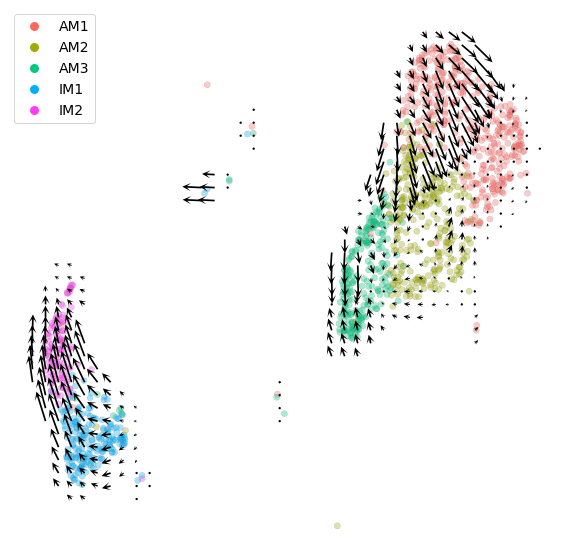

In [40]:
plot(asbestos_macs, macrophages_cmap)
plt.savefig("asbestos-mac-grid.pdf")

In [41]:
at2_cmap = {
    "AT2_1": [1, 0x66 / 255, 0x61 / 255],
    "AT2_2": [0x9e / 255, 0xab / 255, 0],
    "AT2_3": [0, 0xae / 255, 0xfa / 255],
    "AT2_4": [1, 0x3b / 255, 0xf3 / 255],
}

In [42]:
tio2_at2 = default_velocity(
    loom_file="../../SC_14.loom", 
    coords_file="../../at2-umap.csv",
    idents_file="../../at2-ident.csv",
    cmap=at2_cmap
)

/home/nmx5063/.local/share/virtualenvs/rna-velocity-9bSdH9Bk/lib/python3.6/site-packages/loompy/loom_validator.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(path) as f:


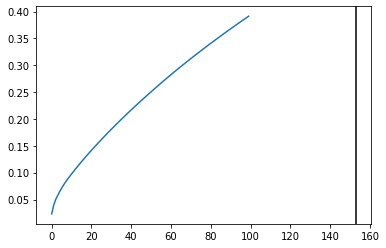

In [44]:
tio2_at2_comps = estimate_n_comps(tio2_at2)

In [47]:
continue_velocity(tio2_at2, tio2_at2_comps)

/home/nmx5063/.local/share/virtualenvs/rna-velocity-9bSdH9Bk/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


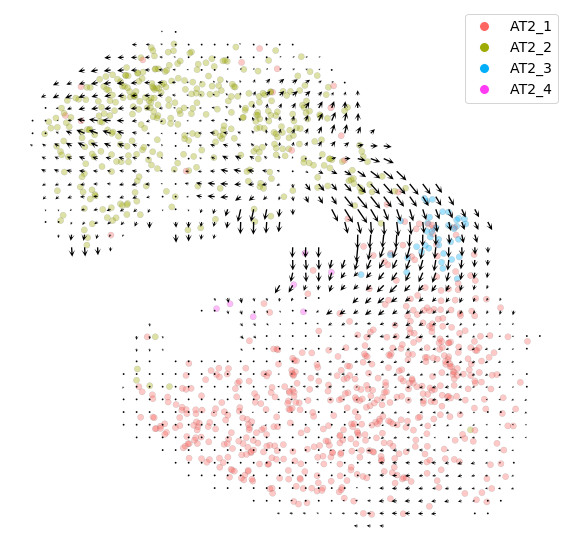

In [49]:
plot(tio2_at2, at2_cmap)
plt.savefig("tio2-at2-grid.pdf")

In [50]:
asbestos_at2 = default_velocity(
    loom_file="../../SC_15.loom", 
    coords_file="../../at2-umap.csv",
    idents_file="../../at2-ident.csv",
    cmap=at2_cmap
)

/home/nmx5063/.local/share/virtualenvs/rna-velocity-9bSdH9Bk/lib/python3.6/site-packages/loompy/loom_validator.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(path) as f:


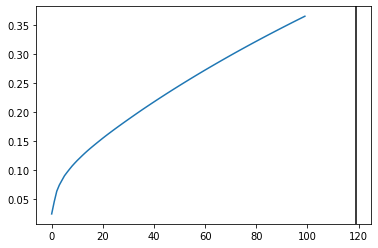

In [51]:
asbestos_at2_comps = estimate_n_comps(asbestos_at2)

In [52]:
continue_velocity(asbestos_at2, asbestos_at2_comps)

/home/nmx5063/.local/share/virtualenvs/rna-velocity-9bSdH9Bk/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


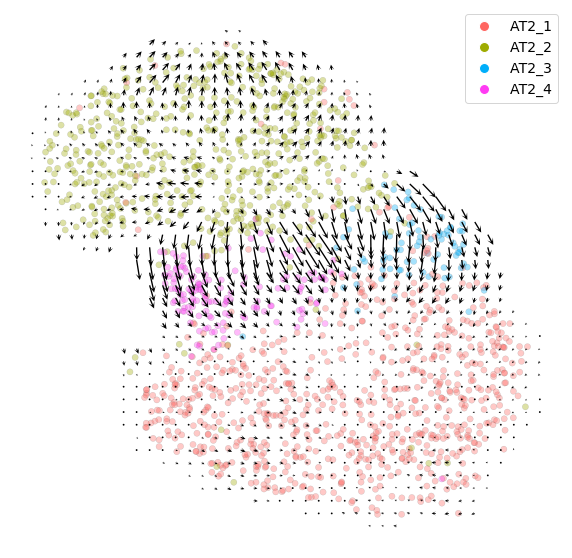

In [54]:
plot(asbestos_at2, at2_cmap)
plt.savefig("asbestos-at2-grid.pdf")